In [114]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
%matplotlib inline
import plotly.graph_objects as go
from ripser import ripser
from persim import plot_diagrams

from plot import *

import sys
sys.path.append("../../")
from DREiMac.dreimac.toroidalcoords import *

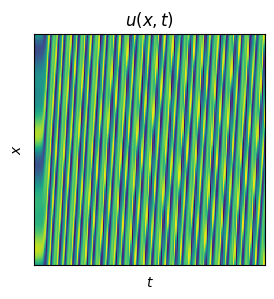

In [178]:
# load and display data

X = np.loadtxt("data/ks.dat")
X.shape
X = X[10:]

plt.figure(figsize=(3,3))
plt.imshow(X[:400].T, cmap='viridis', interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title("$u(x,t)$")
plt.savefig("figures/ks-solution.png", dpi=100)

([], [])

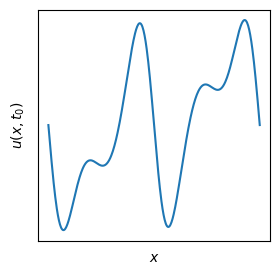

In [179]:
# display example wave 

plt.figure(figsize=(3,3))
plt.plot(X[0])
plt.xlabel("$x$")
plt.ylabel("$u(x,t_0)$")
plt.xticks([])
plt.yticks([])
#plt.savefig("figures/ks-solution-t0.png", dpi=100)


In [180]:
# define sliding window embedding function and use it

def sw(ts, d, tau):
    emb = []
    last = len(ts) - ((d - 1) * tau)
    for i in range(last):
        emb.append(ts[i:i + d * tau:tau])
    return np.array(emb)

d = 5
tau = 4
W = sw(X, d, tau)
n = W.shape[0]
W = W.reshape(n,W.shape[1] * W.shape[2])

/opt/homebrew/Caskroom/miniforge/base/envs/fiberwise-dim-red/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


([], [])

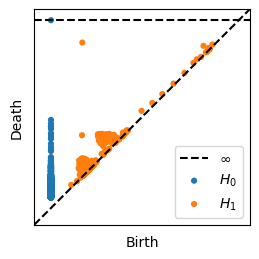

In [181]:
# run persistence

cc = CircularCoords(W, distance_matrix = False, n_landmarks= 1500, prime = 41)
order_by_prominence = prominence_diagram(cc.dgms_[1])

plt.figure(figsize=(3,3))
plot_diagrams(cc.dgms_)
plt.tight_layout()
plt.xticks([])
_ = plt.yticks([])
#plt.savefig("figures/ks-pd.png", dpi=100)

In [182]:
# select two most persistent cohomology classes and get two circular coordinates

alpha = 0.2
how_many_coords = 2
cocycles_idxs = list(map(lambda x: [x], order_by_prominence[:how_many_coords] ))
circ_coords, gram_matrix = cc.get_coordinates(perc = alpha, cocycle_idxs= cocycles_idxs, return_gram_matrix=True)

In [183]:
# do lattice reduction to find a linear combination with lower energy, display change of basis matrix

new_circ_coords, new_gram_matrix, change_basis = reduce_circular_coordinates(circ_coords, gram_matrix)
#print(gram_matrix)
#print(new_gram_matrix)
print(change_basis)

[[ 1.  0.]
 [-5.  1.]]


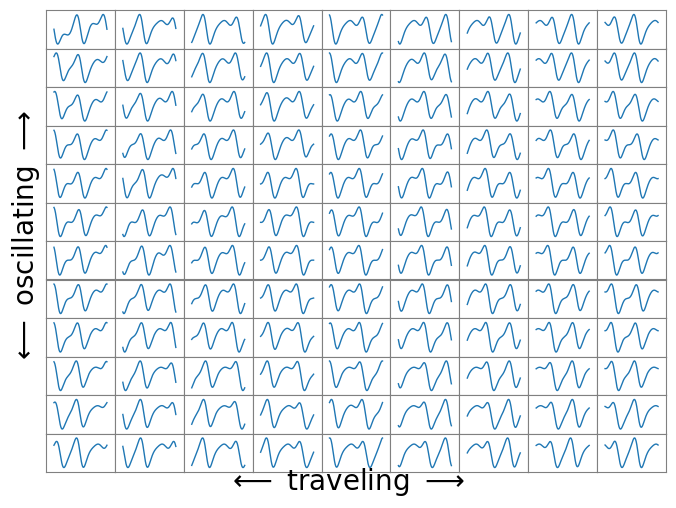

In [184]:
# plot decorrelated coordinates

x_coords = new_circ_coords[0]
y_coords = new_circ_coords[1]

bins_y = 12
bins_x = 9

import matplotlib
matplotlib.rc('axes',edgecolor='grey')

fig, ax = plt.subplots(bins_y,bins_x, figsize=(8,6))
plt.subplots_adjust(hspace=0, wspace=0)
fig.text(0.5, 0.08, r'$\longleftarrow$ traveling $\longrightarrow$', ha='center', fontsize=20)
fig.text(0.08, 0.5, r'$\longleftarrow$ oscillating $\longrightarrow$', va='center', fontsize=20, rotation=90)

def closest(i,j,x_coords,y_coords,bins_x, bins_y):
    return np.argmin(np.linalg.norm(np.array([i/bins_x,j/bins_y]) - np.vstack((x_coords,y_coords)).T, axis=1))

for i in range(bins_x):
    for j in range(bins_y):
        idx = closest(i,j,x_coords,y_coords,bins_x,bins_y)
        ax[j,i].plot(X[idx],linewidth=1)
        ax[j,i].margins(0.15)

        ax[j,i].set_xticks([])
        ax[j,i].set_yticks([])

#plt.savefig("figures/ks-reduced.png", bbox_inches='tight', dpi=200)

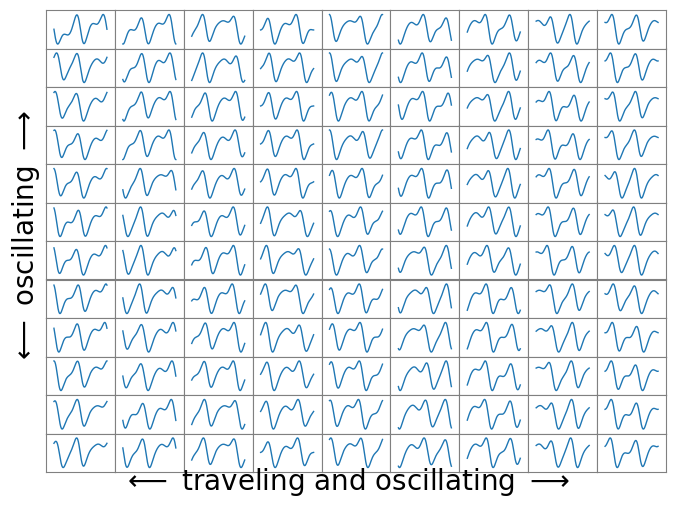

In [185]:
# plot correlated coordinates

x_coords = circ_coords[0]
y_coords = circ_coords[1]


fig, ax = plt.subplots(bins_y,bins_x, figsize=(8,6))
plt.subplots_adjust(hspace=0.0, wspace=0.0)
#fig.set_xlabel(r'----- traveling $\longrightarrow$', fontsize=16, loc="center")
fig.text(0.5, 0.08, r'$\longleftarrow$ traveling and oscillating $\longrightarrow$', ha='center', fontsize=20)
fig.text(0.08, 0.5, r'$\longleftarrow$ oscillating $\longrightarrow$', va='center', fontsize=20, rotation=90)


def closest(i,j,x_coords,y_coords,bins_x, bins_y):
    return np.argmin(np.linalg.norm(np.array([i/bins_x,j/bins_y]) - np.vstack((x_coords,y_coords)).T, axis=1))

for i in range(bins_x):
    for j in range(bins_y):
        idx = closest(i,j,x_coords,y_coords,bins_x,bins_y)
        ax[j,i].plot(X[idx],linewidth=1)
        ax[j,i].margins(0.15)

        ax[j,i].set_xticks([])
        ax[j,i].set_yticks([])

#plt.savefig("figures/ks-unreduced.png", bbox_inches='tight', dpi=200)

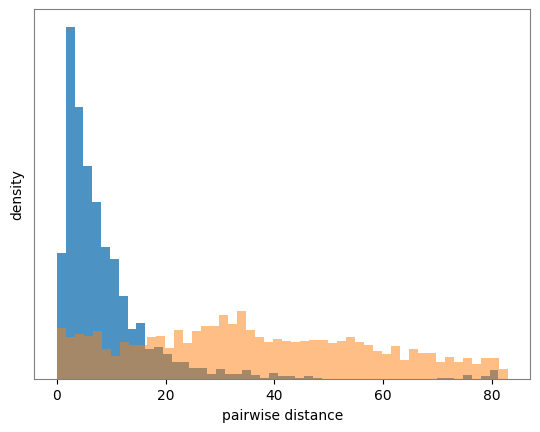

In [186]:
# confirm that x-axis of decorrelated coordinates is only parametrizing traveling

bins = 50

def invariant_distance(t1, t2):
    samples = t1.shape[0]
    d = np.inf
    for i in range(samples):
        d = min(np.linalg.norm(np.roll(t1,i)-t2),d)
    return d

def all_invariant_distances(Y, subsample=30):
    n = Y.shape[0]
    dists = []
    if subsample == False:
        for i in range(n):
            for j in range(i+1,n):
                dists.append(invariant_distance(Y[i],Y[j]))
    else :
        for _ in range(subsample):
            i,j = np.random.choice(a=n, size=2, replace=True)
            dists.append(invariant_distance(Y[i],Y[j]))
    return np.array(dists)


def f(coord):
    period = np.linspace(0, 1, bins, endpoint = False)
    avs = []
    for i in range(bins-1):
        Y = X[:coord.shape[0]][(coord >= period[i]) & (coord < period[i+1])]
        avs.append(all_invariant_distances(Y))
    return np.array(avs).flatten()

h1 = f(new_circ_coords[1])
h2 = f(circ_coords[1])

_ = plt.hist(h1,bins=bins, alpha=0.8)
_ = plt.hist(h2,bins=bins, alpha=0.5)
plt.xlabel("pairwise distance")
plt.ylabel("density")
plt.yticks([])
#plt.xticks([])

plt.savefig("figures/ks-density.png", dpi=100)

In [187]:
# confirm that lattice reduction did decrease energy and correlation

weight = exp_weight(100)
graph_type = "k"
k = 10

print(dirichlet_form_gram_matrix(W,circ_coords,weight,k=k,graph_type=graph_type))
print(dirichlet_form_gram_matrix(W,new_circ_coords,weight,k=k,graph_type=graph_type))

[[  1.10219971   6.13266104]
 [  6.13266104 112.31473746]]
[[ 1.10219971  1.02550298]
 [ 1.02550298 76.63045644]]
